In [1]:
!git clone https://github.com/atikul-islam-sajib/TreeBasedModel.git

Cloning into 'TreeBasedModel'...
remote: Enumerating objects: 915, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 915 (delta 3), reused 8 (delta 3), pack-reused 907
Receiving objects: 100% (915/915), 124.15 MiB | 28.73 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Updating files: 100% (123/123), done.


In [2]:
%cd /content/TreeBasedModel

/content/TreeBasedModel


In [3]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [4]:
!pip install -e .

Obtaining file:///content/TreeBasedModel
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.2/237.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.2 MB/s eta 0:00:00
  Running setup.py develop for AugmentedHierarchicalShrinkage


In [5]:
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.datasets import DATASETS_CLASSIFICATION, DATASET_PATH

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from imodels import get_clean_dataset

#### With K, and Depth

In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from imodels import get_clean_dataset
from joblib import Parallel, delayed

def perform_regression(dataset_name, n_trees=5, k=None, max_features=None):
    # Fetch the dataset
    X, y, feature_names = get_clean_dataset(dataset_name)  # Ensure this function can provide regression datasets

    X = X[:50]
    y = y[:50]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and fit your custom RandomForest for regression
    custom_rf = RandomForest(n_trees=n_trees, treetype='regression', k=k, n_feature=max_features)
    custom_rf.fit(X_train, y_train)

    # Calculate MSE for custom predictions
    custom_mse = mean_squared_error(y_test, custom_rf.predict(X_test))

    # Creating a DataFrame for the result
    result_df = pd.DataFrame({
        'Dataset': [dataset_name],
        'K': [k],
        'Max Features': [max_features],
        'Custom MSE': [custom_mse]
    })

    return result_df

def perform_sklearn_regression(dataset_name, n_estimators=5, max_features=None):
    X, y, _ = get_clean_dataset(dataset_name)  # Ensure this function can provide regression datasets

    X = X[:50]
    y = y[:50]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, random_state=42)
    model.fit(X_train, y_train)
    mse = mean_squared_error(y_test, model.predict(X_test))

    # Creating a DataFrame for the result
    result_df = pd.DataFrame({
        'Dataset': [dataset_name],
        'Max Features': [max_features],
        'Sklearn MSE': [mse]
    })

    return result_df

# Parameters
regression_datasets = ["fico", "credit_g", "juvenile_clean"]

# k_values = [1, 2, 4, 6, 8, 10, 15]
# max_features_values = [0.2, 0.4, 0.6, 0.8]


k_values = [1, 2]
max_features_values = [0.4, 0.6]

n_jobs = -1  # Use all available CPUs

# Initialization of DataFrames
regression_results = pd.DataFrame()
sklearn_regression_results = pd.DataFrame()

# Sklearn regression parallel execution
sklearn_tasks = [
    delayed(perform_sklearn_regression)(dataset_name, n_estimators=5, max_features=max_features)
    for dataset_name in regression_datasets
    for max_features in max_features_values
]

# Execute sklearn regression tasks in parallel
sklearn_results_list = Parallel(n_jobs=n_jobs, verbose=10)(sklearn_tasks)

# Aggregate sklearn regression results
for result in sklearn_results_list:
    sklearn_regression_results = pd.concat([sklearn_regression_results, result], ignore_index=True)

# Custom regression parallel execution
custom_tasks = [
    delayed(perform_regression)(dataset_name, n_trees=5, k=k, max_features=max_features)
    for dataset_name in regression_datasets
    for k in k_values
    for max_features in max_features_values
]

# Execute custom regression tasks in parallel
custom_results_list = Parallel(n_jobs=n_jobs, verbose=10)(custom_tasks)

# Aggregate custom regression results
for result in custom_results_list:
    regression_results = pd.concat([regression_results, result], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    4.7s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   10.1s finished


In [8]:
# Find the best combination of parameters for the custom RandomForest model
best_combinations_custom_d_k = regression_results.groupby('Dataset').apply(lambda x: x.loc[x['Custom MSE'].idxmax()]).reset_index(drop=True)

# Find the best combination for the sklearn RandomForest model
best_combinations_sklearn = sklearn_regression_results.groupby('Dataset').apply(lambda x: x.loc[x['Sklearn MSE'].idxmax()]).reset_index(drop=True)

# Philip Code without changing depth

In [9]:
!git clone https://github.com/Heity94/AugmentedHierarchicalShrinkage.git

Cloning into 'AugmentedHierarchicalShrinkage'...
remote: Enumerating objects: 903, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 903 (delta 72), reused 70 (delta 70), pack-reused 822
Receiving objects: 100% (903/903), 124.13 MiB | 12.15 MiB/s, done.
Resolving deltas: 100% (500/500), done.
Updating files: 100% (123/123), done.


In [10]:
%cd AugmentedHierarchicalShrinkage/

/content/TreeBasedModel/AugmentedHierarchicalShrinkage


In [11]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from imodels import get_clean_dataset
from joblib import Parallel, delayed

def perform_regression(dataset_name, n_trees=25, k=None, max_features=None):
    # Fetch the dataset
    X, y, feature_names = get_clean_dataset(dataset_name)  # Ensure this function can provide regression datasets

    X = X[:50]
    y = y[:50]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and fit your custom RandomForest for regression
    custom_rf = RandomForest(n_trees=n_trees, treetype='regression', k=k, n_feature=max_features)
    custom_rf.fit(X_train, y_train)

    # Calculate MSE for custom predictions
    custom_mse = mean_squared_error(y_test, custom_rf.predict(X_test))

    # Creating a DataFrame for the result
    result_df = pd.DataFrame({
        'Dataset': [dataset_name],
        'K': [k],
        'Max Features': [max_features],
        'Custom MSE': [custom_mse]
    })

    return result_df

def perform_sklearn_regression(dataset_name, n_estimators=25, max_features=None):
    X, y, _ = get_clean_dataset(dataset_name)  # Ensure this function can provide regression datasets

    X = X[:50]
    y = y[:50]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, random_state=42)
    model.fit(X_train, y_train)
    mse = mean_squared_error(y_test, model.predict(X_test))

    # Creating a DataFrame for the result
    result_df = pd.DataFrame({
        'Dataset': [dataset_name],
        'Max Features': [max_features],
        'Sklearn MSE': [mse]
    })

    return result_df

# Parameters
regression_datasets = ["fico", "credit_g", "juvenile_clean"]
# k_values = [1, 2, 4, 6, 8, 10, 15]
# max_features_values = [0.2, 0.4, 0.6, 0.8]

k_values = [1, 2]
max_features_values = [0.4, 0.6]


n_jobs = -1  # Use all available CPUs

# Initialization of DataFrames
regression_results = pd.DataFrame()
sklearn_regression_results = pd.DataFrame()

# Sklearn regression parallel execution
sklearn_tasks = [
    delayed(perform_sklearn_regression)(dataset_name, n_estimators=5, max_features=max_features)
    for dataset_name in regression_datasets
    for max_features in max_features_values
]

# Execute sklearn regression tasks in parallel
sklearn_results_list = Parallel(n_jobs=n_jobs, verbose=10)(sklearn_tasks)

# Aggregate sklearn regression results
for result in sklearn_results_list:
    sklearn_regression_results = pd.concat([sklearn_regression_results, result], ignore_index=True)

# Custom regression parallel execution
custom_tasks = [
    delayed(perform_regression)(dataset_name, n_trees=5, k=k, max_features=max_features)
    for dataset_name in regression_datasets
    for k in k_values
    for max_features in max_features_values
]

# Execute custom regression tasks in parallel
custom_results_list = Parallel(n_jobs=n_jobs, verbose=10)(custom_tasks)

# Aggregate custom regression results
for result in custom_results_list:
    regression_results = pd.concat([regression_results, result], ignore_index=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    0.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.7s finished


In [12]:
# Find the best combination of parameters for the custom RandomForest model
best_combinations_custom_without_k = regression_results.groupby('Dataset').apply(lambda x: x.loc[x['Custom MSE'].idxmax()]).reset_index(drop=True)

# Find the best combination for the sklearn RandomForest model
best_combinations_sklearn = sklearn_regression_results.groupby('Dataset').apply(lambda x: x.loc[x['Sklearn MSE'].idxmax()]).reset_index(drop=True)

I would like a side-by-side comparison of the performance of our three methods: (i) sklearn RF, (ii) previous version of custom RF (not using depth, only K), and (iii) the latest version of custom RF ( using depth plus K)

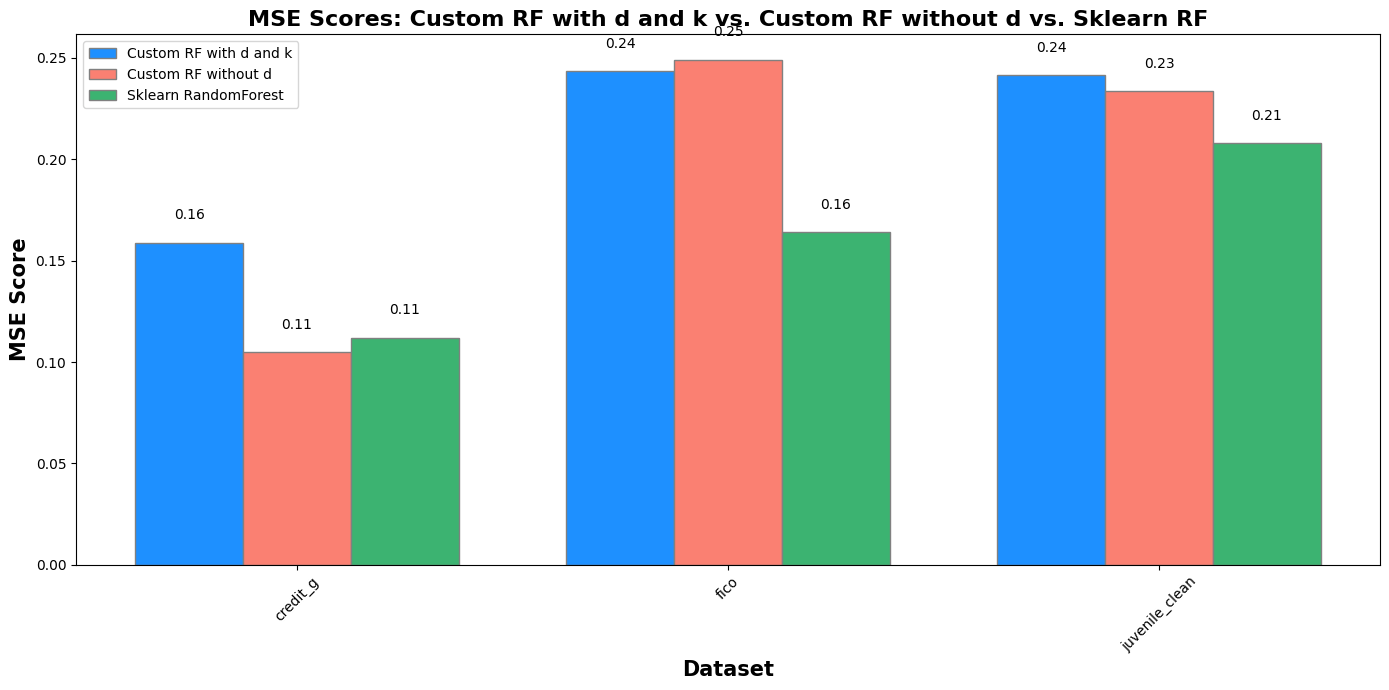

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(14, 7))
width = 0.25  # Adjusting the width of the bars to accommodate three groups

# Assuming best_combinations_custom_d_k, best_combinations_custom_without_d, and best_combinations_sklearn are available
r1 = np.arange(len(best_combinations_custom_d_k['Dataset']))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

# Plotting
plt.bar(r1, best_combinations_custom_d_k['Custom MSE'], color='dodgerblue', width=width, edgecolor='grey', label='Custom RF with d and k')
plt.bar(r2, best_combinations_custom_without_k['Custom MSE'], color='salmon', width=width, edgecolor='grey', label='Custom RF without d')
plt.bar(r3, best_combinations_sklearn['Sklearn MSE'], color='mediumseagreen', width=width, edgecolor='grey', label='Sklearn RandomForest')

# Adding xticks and labels
plt.xlabel('Dataset', fontweight='bold', fontsize=15)
plt.xticks([r + width for r in range(len(best_combinations_custom_d_k['Dataset']))], best_combinations_custom_d_k['Dataset'], rotation=45)
plt.ylabel('MSE Score', fontweight='bold', fontsize=15)
plt.title('MSE Scores: Custom RF with d and k vs. Custom RF without d vs. Sklearn RF', fontweight='bold', fontsize=16)
plt.legend()

# Adding value labels on top of bars
for i in range(len(r1)):
    plt.text(r1[i], best_combinations_custom_d_k['Custom MSE'].iloc[i] + 0.01, f"{best_combinations_custom_d_k['Custom MSE'].iloc[i]:.2f}", ha='center', va='bottom')
    plt.text(r2[i], best_combinations_custom_without_k['Custom MSE'].iloc[i] + 0.01, f"{best_combinations_custom_without_k['Custom MSE'].iloc[i]:.2f}", ha='center', va='bottom')
    plt.text(r3[i], best_combinations_sklearn['Sklearn MSE'].iloc[i] + 0.01, f"{best_combinations_sklearn['Sklearn MSE'].iloc[i]:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()